### Filtering for only *tridentata* diploids

Uses ARTR_chr.biallelic.vcf.gz to start

Sample names have been extracted to subset using:   
- zcat ARTR_chr.vcf.gz | bcftools query -l | sort > sample_index.txt

In [1]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [2]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [3]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering"

In [4]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering


In [5]:
vcf_file = os.path.join(analysis_dir, "ARTR_chr.biallelic.recode.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/ARTR_chr.biallelic.recode.vcf.gz'

### keep only AT2 individuals

In [6]:
sample_names = pd.read_csv('sample_index.txt',header=None,names=['sample'])
sample_names.head()

,sample
0,AT2_BB_1
1,AT2_BB_10
2,AT2_BB_11
3,AT2_BB_12
4,AT2_BB_13


In [7]:
AT2_indv = [s for s in sample_names['sample'] if 'AT2' in s]

In [8]:
len(AT2_indv), AT2_indv[0]

(235, 'AT2_BB_1')

In [9]:
with open(os.path.join(analysis_dir, "AT2_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in AT2_indv:
        o.write("%s\n" % elem)

In [10]:
!$vcftools --gzvcf $vcf_file \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--keep {os.path.join(analysis_dir, "AT2_indv.txt")} \
--out {os.path.join(analysis_dir, "AT2_chr.biallelic")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/ARTR_chr.biallelic.recode.vcf.gz
	--keep /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/AT2_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/AT2_chr.biallelic
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 235 out of 708 Individuals
Outputting VCF file...
After filtering, kept 2766918 out of a possible 2766918 Sites
Run Time = 2245.00 seconds


In [11]:
vcf_AT2 = "AT2_chr.biallelic.recode.vcf" 
vcf_AT2_gz = "%s.gz" % vcf_AT2
!$bgzip -c $vcf_AT2 > {vcf_AT2_gz}
!$tabix {vcf_AT2_gz}

## Remove by MAF, missing, and thin next

In [ ]:
!$vcftools \
--maf 0.01 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_AT2_gz \
--out $'AT2_chr_thin100_MAF1'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AT2_chr.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.01
	--thin 100
	--out AT2_chr_thin100_MAF1
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 235 out of 235 Individuals
Outputting VCF file...


In [ ]:
vcf_filtered = "AT2_chr_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [ ]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Calulate missing data and private alleles using vcfR


In [6]:
%load_ext rpy2.ipython

In [9]:
%%R
require(readr)
library(data.table)
require(MASS)
require(ggplot2)
library(vcfR)

source('/data/gpfs/home/tfaske/g/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/')

R[write to console]: Loading required package: readr

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: ggplot2

R[write to console]: 
   *****       ***   vcfR   ***       *****
   This is vcfR 1.8.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****




In [10]:
%%R
vcf <- read.vcfR("AT2_chr_thin100_MAF1.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [11]:
%%R
#get pl 
dp <- extract.gt(vcf, element = 'DP')

In [12]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 458910
 [1] "CM042338.1:22493"  "CM042338.1:59140"  "CM042338.1:97078" 
 [4] "CM042338.1:106063" "CM042338.1:126072" "CM042338.1:128439"
 [7] "CM042338.1:129199" "CM042338.1:129763" "CM042338.1:130233"
[10] "CM042338.1:169173"
                  AV2_AN_1 AV2_AN_2 AV2_AN_3 AV2_AN_4 AV2_AN_5
CM042338.1_22493  "0"      "0"      "0"      "0"      "0"     
CM042338.1_59140  "0"      "0"      "3"      "0"      "0"     
CM042338.1_97078  "0"      "0"      "0"      "0"      "0"     
CM042338.1_106063 "0"      "0"      "0"      "0"      "0"     
CM042338.1_126072 "1"      "0"      "1"      "0"      "0"     


In [13]:
%%R
str(dp[1:5,1:5])

 chr [1:5, 1:5] "0" "0" "0" "0" "1" "0" "0" "0" "0" "0" "0" "3" "0" "0" "1" ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5] "CM042338.1_22493" "CM042338.1_59140" "CM042338.1_97078" "CM042338.1_106063" ...
  ..$ : chr [1:5] "AV2_AN_1" "AV2_AN_2" "AV2_AN_3" "AV2_AN_4" ...


#### Calculate missing loci and individual

In [14]:
%%R
nindv <- ncol(dp)
nloci <- nrow(dp)
print(nloci)
print(nindv)

[1] 458910
[1] 172


In [15]:
%%R
miss_loci <- apply(dp,1, function(d) length(which(d == "0"))/nindv)
#miss_loci <- apply(dp[,1:100],1, function(d) (length(which(d == "0"))/100))
print(summary(miss_loci))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.9942  1.0000  0.9244  1.0000  1.0000 


In [16]:
%%R
print(length(which(miss_loci <= .30)))
print(length(which(miss_loci <= .40)))
print(length(which(miss_loci <= .50)))
print(length(which(miss_loci <= .60)))
print(length(which(miss_loci <= .70)))

[1] 13533
[1] 21012
[1] 29811
[1] 38646
[1] 48174


In [17]:
%%R
keep_miss <- pos_ID[which(miss_loci <= .60)]
length(keep_miss)

[1] 38646


In [18]:
%%R
keep_miss60_df <- data.frame(chrom=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[1]),
                             pos=sapply(keep_miss,function(s) unlist(strsplit(as.character(s),':'))[2]))
print(head(keep_miss60_df))    
write.table(keep_miss60_df,'keep_miss60.txt',quote=F,row.names=F,col.names=F,sep='\t')

                        chrom     pos
CM042338.1:398145  CM042338.1  398145
CM042338.1:1342981 CM042338.1 1342981
CM042338.1:1496832 CM042338.1 1496832
CM042338.1:1942811 CM042338.1 1942811
CM042338.1:2125877 CM042338.1 2125877
CM042338.1:2385838 CM042338.1 2385838


In [19]:
!head keep_miss60.txt

CM042338.1	398145
CM042338.1	1342981
CM042338.1	1496832
CM042338.1	1942811
CM042338.1	2125877
CM042338.1	2385838
CM042338.1	3792588
CM042338.1	6087026
CM042338.1	6148025
CM042338.1	6353755


In [21]:
!$vcftools --vcf {"AT2_chr_thin100_MAF1.recode.vcf"} \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "keep_miss60.txt")} \
--out {os.path.join(analysis_dir, "AT2_chr_miss60_thin100_MAF1")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AV2_chr_thin100_MAF1.recode.vcf
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/AV2_chr_miss60_thin100_MAF1
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/keep_miss60.txt
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 172 out of 172 Individuals
Outputting VCF file...
After filtering, kept 38646 out of a possible 458910 Sites
Run Time = 20.00 seconds


In [22]:
vcf_filtered = "AV2_chr_miss60_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [31]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AT2_chr_miss70_thin100_MAF1.recode.vcf.gz
	--depth
	--out AT2_chr_miss70_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 235 out of 235 Individuals
Outputting Mean Depth by Individual
After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 19.00 seconds


In [33]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,477316,0.360369
1,AT2_BB_11,477316,0.249962
2,AT2_BB_12,477316,0.212310
3,AT2_BB_13,477316,0.315489
4,AT2_BB_14,477316,0.444678


In [34]:
depth_df.MEAN_DEPTH.describe()

count    235.000000
mean       0.267208
std        0.090410
min        0.002910
25%        0.212249
50%        0.261904
75%        0.324943
max        0.539852
Name: MEAN_DEPTH, dtype: float64

In [40]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= .05]),len(depth_df[depth_df.MEAN_DEPTH <= .1]), len(depth_df[depth_df.MEAN_DEPTH <= .15])


(235, 5, 8, 19)

In [49]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= .1]

In [51]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [52]:
!cat bad_indv.txt

INDV
AT2_EW_38
AT2_KN_90
AT2_LN_95
AT2_LN_97
AT2_OC_1
AT2_RB_2
AT2_SS_8
AT2_SS_9


In [53]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf AT2_chr_miss70_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 227 out of 235 Individuals
Outputting VCF file...
After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 229.00 seconds


In [54]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [55]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [56]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 227 out of 227 Individuals
Outputting Mean Depth by Individual
After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 19.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 227 out of 227 Individuals
Outputting Depth for Each Site
After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 23.00 seco

After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 17.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 227 out of 227 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 477316 out of a possible 477316 Sites
Run Time = 25.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 227 out of 227 Individuals
Outputting Ind

In [57]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [58]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz'

In [59]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [60]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
CM042338.1-22493,1,1,0.004405,0.004405,454,0,0,0,7.82756,2,...,227.000000,1.238848e-67,1.000000e+00,1.238848e-67,C,G,0.500000,0.500000,0.500000,-0.995595
CM042338.1-59115,148,412,0.651982,1.396050,454,0,0,0,999.00000,2,...,0.588713,1.000000e+00,1.000000e+00,5.860657e-01,A,T,0.048458,0.951542,0.048458,-0.048611
CM042338.1-97078,0,0,0.000000,0.000000,454,0,0,0,35.79330,2,...,227.000000,1.238848e-67,1.000000e+00,1.238848e-67,T,G,0.500000,0.500000,0.500000,-0.995595
CM042338.1-106063,6,12,0.026432,0.052396,454,0,0,0,999.00000,2,...,211.348800,3.409456e-60,1.000000e+00,3.396652e-60,T,C,0.504405,0.495595,0.495595,-0.960582
CM042338.1-126072,229,657,1.008810,1.884880,454,0,0,0,999.00000,2,...,36.975000,5.890363e-07,5.890363e-07,1.000000e+00,C,G,0.887665,0.112335,0.112335,0.404904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CM042346.1-338265730,75,193,0.330396,0.744337,454,0,0,0,999.00000,2,...,0.028150,1.000000e+00,1.000000e+00,9.779984e-01,T,A,0.988987,0.011013,0.011013,-0.008909
CM042346.1-338268601,0,0,0.000000,0.000000,454,0,0,0,54.99990,2,...,227.000000,1.238848e-67,1.000000e+00,1.238848e-67,A,G,0.500000,0.500000,0.500000,-0.995595
CM042346.1-338274068,0,0,0.000000,0.000000,454,0,0,0,7.82756,2,...,227.000000,1.238848e-67,1.000000e+00,1.238848e-67,G,T,0.500000,0.500000,0.500000,-0.995595
CM042346.1-338287589,0,0,0.000000,0.000000,454,0,0,0,5.49146,2,...,227.000000,1.238848e-67,1.000000e+00,1.238848e-67,G,A,0.500000,0.500000,0.500000,-0.995595


In [61]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
CM042338.1-22493,CM042338.1,22493,2,454,C:0.5,G:0.5
CM042338.1-59115,CM042338.1,59115,2,454,A:0.0484581,T:0.951542
CM042338.1-97078,CM042338.1,97078,2,454,T:0.5,G:0.5
CM042338.1-106063,CM042338.1,106063,2,454,T:0.504405,C:0.495595
CM042338.1-126072,CM042338.1,126072,2,454,C:0.887665,G:0.112335
...,...,...,...,...,...,...
CM042346.1-338265730,CM042346.1,338265730,2,454,T:0.988987,A:0.0110132
CM042346.1-338268601,CM042346.1,338268601,2,454,A:0.5,G:0.5
CM042346.1-338274068,CM042346.1,338274068,2,454,G:0.5,T:0.5
CM042346.1-338287589,CM042346.1,338287589,2,454,G:0.5,A:0.5


In [62]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
CM042338.1-22493,CM042338.1,22493,0/227/0,56.75/113.50/56.75,227.000000,1.238848e-67,1.000000e+00,1.238848e-67
CM042338.1-59115,CM042338.1,59115,0/22/205,0.53/20.93/205.53,0.588713,1.000000e+00,1.000000e+00,5.860657e-01
CM042338.1-97078,CM042338.1,97078,0/227/0,56.75/113.50/56.75,227.000000,1.238848e-67,1.000000e+00,1.238848e-67
CM042338.1-106063,CM042338.1,106063,3/223/1,57.75/113.49/55.75,211.348800,3.409456e-60,1.000000e+00,3.396652e-60
CM042338.1-126072,CM042338.1,126072,188/27/12,178.86/45.27/2.86,36.975000,5.890363e-07,5.890363e-07,1.000000e+00
...,...,...,...,...,...,...,...,...
CM042346.1-338265730,CM042346.1,338265730,222/5/0,222.03/4.94/0.03,0.028150,1.000000e+00,1.000000e+00,9.779984e-01
CM042346.1-338268601,CM042346.1,338268601,0/227/0,56.75/113.50/56.75,227.000000,1.238848e-67,1.000000e+00,1.238848e-67
CM042346.1-338274068,CM042346.1,338274068,0/227/0,56.75/113.50/56.75,227.000000,1.238848e-67,1.000000e+00,1.238848e-67
CM042346.1-338287589,CM042346.1,338287589,0/227/0,56.75/113.50/56.75,227.000000,1.238848e-67,1.000000e+00,1.238848e-67


In [63]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [64]:
loci_df.SUM_DEPTH.describe()

count    477316.000000
mean         62.511384
std         227.943165
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max       52511.000000
Name: SUM_DEPTH, dtype: float64

In [65]:
loci_df.MEAN_DEPTH.describe()

count    477316.000000
mean          0.275381
std           1.004155
min           0.000000
25%           0.000000
50%           0.004405
75%           0.044053
max         231.326000
Name: MEAN_DEPTH, dtype: float64

In [66]:
loci_df.QUAL.describe()

count    477316.000000
mean        286.072864
std         433.694289
min           3.127520
25%           7.827560
50%          26.049500
75%         999.000000
max         999.000000
Name: QUAL, dtype: float64

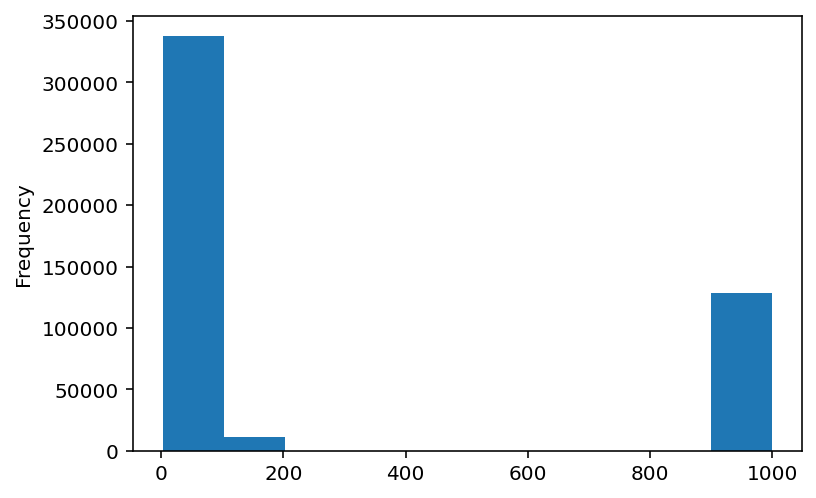

In [67]:
loci_df.QUAL.plot(kind="hist");

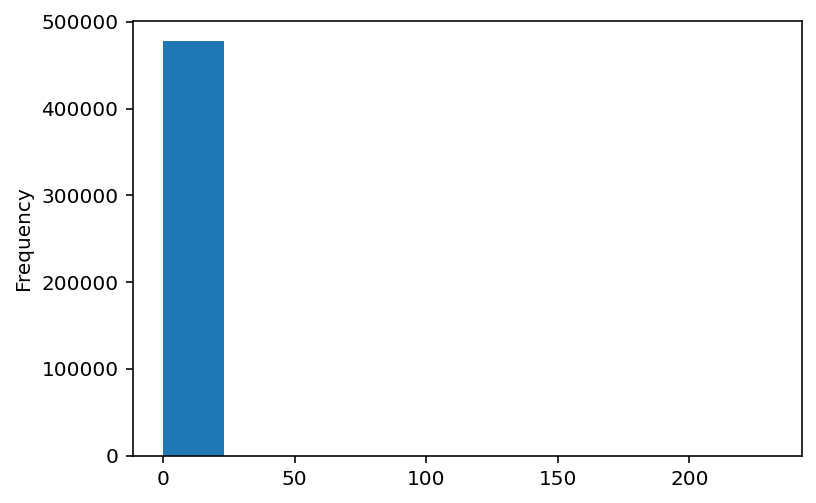

In [68]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [69]:
len(loci_df[loci_df.Fis == -9])

0

In [70]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=200])

(477300, 52682)

In [72]:
len(loci_df[loci_df.MEAN_DEPTH > 30 ]),len(loci_df[loci_df.MEAN_DEPTH >= 1])

(13, 47152)

In [73]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

14543

In [74]:
len(loci_df[loci_df.QUAL >  20]), len(loci_df[loci_df.QUAL > 50]), len(loci_df[loci_df.QUAL > 100])

(246566, 177748, 140542)

In [76]:
 len(loci_df[loci_df.Fis >= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(100086, 508)

In [81]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 1) & 
                  (df.MEAN_DEPTH < 30) & 
                  (df.QUAL >= 100) & 
                  (df.MAF >= 0.01) &
                  (df.Fis >= -0.5)]

In [82]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(45387, 25)

In [83]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [84]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AT2/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 227 out of 227 Individuals
Outputting VCF file...
After filtering, kept 45387 out of a possible 477316 Sites
Run Time = 27.00 seconds


In [85]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

### Miss indv!

In [70]:
%%R
vcf <- read.vcfR("good_snps.recode.vcf", verbose = FALSE)

#get positions
chrom <- getCHROM(vcf)
pos <- getPOS(vcf)
pos_ID <- paste(chrom,pos,sep = ':')

In [71]:
%%R
#get DP 
dp <- extract.gt(vcf, element = 'DP')

In [72]:
%%R
## check out PL and pos_ID
print(length(pos_ID))
print(pos_ID[1:10])
dp[1:5,1:5]

[1] 9973
 [1] "CM042338.1:1496832"  "CM042338.1:6087026"  "CM042338.1:7214312" 
 [4] "CM042338.1:7629194"  "CM042338.1:8076042"  "CM042338.1:8530989" 
 [7] "CM042338.1:8548932"  "CM042338.1:8655617"  "CM042338.1:8698319" 
[10] "CM042338.1:10453589"
                   AV2_AN_1 AV2_AN_2 AV2_AN_3 AV2_AN_4 AV2_AN_5
CM042338.1_1496832 "5"      "2"      "4"      "0"      "1"     
CM042338.1_6087026 "2"      "1"      "3"      "1"      "3"     
CM042338.1_7214312 "3"      "3"      "4"      "7"      "6"     
CM042338.1_7629194 "0"      "0"      "0"      "1"      "0"     
CM042338.1_8076042 "2"      "1"      "6"      "1"      "0"     


In [73]:
%%R
ID <- colnames(dp)
print(length(ID))
print(ID[1:10])

[1] 171
 [1] "AV2_AN_1"  "AV2_AN_2"  "AV2_AN_3"  "AV2_AN_4"  "AV2_AN_5"  "AV2_AN_6" 
 [7] "AV2_AN_7"  "AV2_AN_8"  "AV2_AS_61" "AV2_AS_62"


In [74]:
%%R
nloci <- nrow(dp)
#print(nloci)

miss_indv <- apply(dp,2, function(d) length(which(d == "0"))/nloci)
print(length(miss_indv))
print(summary(miss_indv))

[1] 171
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0750  0.1219  0.1681  0.1760  0.2115  0.6503 


In [75]:
%%R
for (perc in seq(.1,.9,by=.1)){
    print(paste0('number of individuals with greater than ',perc*100,'% missing data.....  ',
                 length(which(miss_indv >= perc))))
}

[1] "number of individuals with greater than 10% missing data.....  159"
[1] "number of individuals with greater than 20% missing data.....  54"
[1] "number of individuals with greater than 30% missing data.....  6"
[1] "number of individuals with greater than 40% missing data.....  2"
[1] "number of individuals with greater than 50% missing data.....  1"
[1] "number of individuals with greater than 60% missing data.....  1"
[1] "number of individuals with greater than 70% missing data.....  0"
[1] "number of individuals with greater than 80% missing data.....  0"
[1] "number of individuals with greater than 90% missing data.....  0"


In [76]:
%%R
miss60_indv_df <- data.frame(INDV=ID[which(miss_indv >= .40)])
miss60_indv_df
write.table(miss60_indv_df,'miss60_indv.txt',quote=F,row.names=F,col.names=T)

### use vcftools to remove individuals and loci based off above parameters

In [77]:
!$vcftools --gzvcf $snps_gz \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "miss60_indv.txt")} \
--out {os.path.join(analysis_dir, "final_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/good_snps.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/miss60_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/final_snps
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 169 out of 171 Individuals
Outputting VCF file...
After filtering, kept 9973 out of a possible 9973 Sites
Run Time = 5.00 seconds


In [78]:
final_snps = os.path.join(analysis_dir, "final_snps.recode.vcf")
final_snps_gz = final_snps + ".gz"
!$bgzip -c {final_snps} > {final_snps_gz}
!$tabix {final_snps_gz}

# Make 012

In [79]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/final_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 169 out of 169 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 9973 out of a possible 9973 Sites
Run Time = 1.00 seconds


# Get coverage per individual

In [80]:
f = os.path.join(analysis_dir, "final_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/final_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/AV2/filtering/final_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 169 out of 169 Individuals
Outputting Mean Depth by Individual
After filtering, kept 9973 out of a possible 9973 Sites
Run Time = 0.00 seconds


In [81]:
depth_file = os.path.join(analysis_dir, "final_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AV2_AN_1,9973,3.60072
1,AV2_AN_2,9973,2.95197
2,AV2_AN_3,9973,2.45002
3,AV2_AN_4,9973,2.70480
4,AV2_AN_5,9973,2.24827


In [82]:
depth_df.MEAN_DEPTH.describe()

count    169.000000
mean       3.221873
std        0.937762
min        1.465460
25%        2.505260
50%        3.060960
75%        3.600720
max        6.261310
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [83]:
!rm snps*

rm: cannot remove ‘snps*’: No such file or directory


In [84]:
!rm *vcf